# Getting Started

This section sets up the environment for access to the Universal Sentence Encoder on TF Hub and provides examples of applying the encoder to words, sentences, and paragraphs.
Tutorial followed:
https://www.dlology.com/blog/keras-meets-universal-sentence-encoder-transfer-learning-for-text-data/

In [1]:
# Install the latest Tensorflow version.
!pip3 install --quiet "tensorflow>=1.7"
# Install TF-Hub.
!pip3 install --quiet tensorflow-hub
!pip3 install seaborn

More detailed information about installing Tensorflow can be found at [https://www.tensorflow.org/install/](https://www.tensorflow.org/install/).

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import keras.layers as layers
from keras.models import Model
from keras import backend as K
np.random.seed(10)

W0513 08:26:49.199342 139779932305280 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14
Using TensorFlow backend.


In [0]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3" #@param ["https://tfhub.dev/google/universal-sentence-encoder/2", "https://tfhub.dev/google/universal-sentence-encoder-large/3"]

In [4]:
# Import the Universal Sentence Encoder's TF Hub module
embed = hub.Module(module_url)


Instructions for updating:
Colocations handled automatically by placer.


W0513 08:27:13.354345 139779932305280 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


In [12]:
embed_size = embed.get_output_info_dict()['default'].get_shape()[1].value
embed_size

512

In [0]:
df=pd.read_csv("labeled_data.csv")

df_train=df[['class', 'tweet']]
# df.class = df.class.astype('category')


In [0]:
df_train.columns = ["label","text"]

In [7]:
df_train.head()

,label,text
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [8]:
df_train.label = df_train.label.astype('category')


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [9]:
category_counts = len(df_train.label.cat.categories)
category_counts

3

In [0]:
def UniversalEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]

In [28]:
input_text = layers.Input(shape=(1,), dtype=tf.string)
embedding = layers.Lambda(UniversalEmbedding, output_shape=(embed_size,))(input_text)
dense = layers.Dense(256, activation='relu')(embedding)
pred = layers.Dense(category_counts, activation='softmax')(dense)
model = Model(inputs=[input_text], outputs=pred)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0513 08:42:20.056455 139779932305280 saver.py:1483] Saver not created because there are no variables in the graph to restore


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
lambda_3 (Lambda)            (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 771       
Total params: 132,099
Trainable params: 132,099
Non-trainable params: 0
_________________________________________________________________


In [0]:
hate=df_train[df_train.label==0]
offensive=df_train[df_train.label==1]
neutral=df_train[df_train.label==2]

In [0]:
hate=hate.sample(frac=1)
offensive=offensive=offensive.sample(frac=1)
neutral=neutral.sample(frac=1)

In [0]:
new_hate=hate[:min(len(hate), len(offensive), len(neutral))]
new_off=offensive[:min(len(hate), len(offensive), len(neutral))]
new_neutral=neutral[:min(len(hate), len(offensive), len(neutral))]

In [0]:
new_hate = new_hate.append(new_off)
new_hate=new_hate.append(new_neutral)
df_train=new_hate

In [0]:
train_text = df_train['text'].tolist()
train_text = np.array(train_text, dtype=object)[:, np.newaxis]

train_label = np.asarray(pd.get_dummies(df_train.label), dtype = np.int8)

In [21]:
train_text.shape

(4290, 1)

In [23]:
train_label.shape

(4290, 3)

## Train Keras model and save weights
This only train and save our Keras layers not the embed module' weights.

In [29]:
with tf.Session() as session:
  K.set_session(session)
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  history = model.fit(train_text, 
            train_label,
            validation_split=0.2,
            epochs=15,
            batch_size=32)
  model.save_weights('./model.h5')

Train on 3432 samples, validate on 858 samples
Epoch 1/15
3432/3432 [==============================] - 8s 2ms/step - loss: 0.6982 - acc: 0.7165 - val_loss: 0.7775 - val_acc: 0.6865
Epoch 2/15
3432/3432 [==============================] - 4s 1ms/step - loss: 0.5297 - acc: 0.7788 - val_loss: 0.5774 - val_acc: 0.7774
Epoch 3/15
3432/3432 [==============================] - 4s 1ms/step - loss: 0.5018 - acc: 0.7952 - val_loss: 0.6216 - val_acc: 0.7657
Epoch 4/15
3432/3432 [==============================] - 3s 957us/step - loss: 0.4871 - acc: 0.7966 - val_loss: 0.6067 - val_acc: 0.7681
Epoch 5/15
3432/3432 [==============================] - 3s 927us/step - loss: 0.4701 - acc: 0.8086 - val_loss: 0.6703 - val_acc: 0.7354
Epoch 6/15
3432/3432 [==============================] - 3s 936us/step - loss: 0.4565 - acc: 0.8167 - val_loss: 0.5789 - val_acc: 0.7902
Epoch 7/15
3432/3432 [==============================] - 3s 934us/step - loss: 0.4396 - acc: 0.8223 - val_loss: 0.4901 - val_acc: 0.8193
Epoch 8

## Make predictions

In [0]:
# new_text = list(s.comments)
# new_text = np.array(new_text, dtype=object)[:, np.newaxis]
new_text=train_text
with tf.Session() as session:
  K.set_session(session)
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  model.load_weights('./model.h5')  
  predicts = model.predict(new_text, batch_size=32)

In [0]:
categories = df_train.label.cat.categories.tolist()
predict_logits = predicts.argmax(axis=1)
predict_labels = [categories[logit] for logit in predict_logits]
predict_labels

In [40]:
df_train.label

10929    0
731      0
15654    0
6487     0
5362     0
14198    0
17757    0
23325    0
2704     0
6348     0
5513     0
18038    0
3006     0
13413    0
12254    0
2521     0
13722    0
20266    0
6454     0
6683     0
18676    0
15269    0
5580     0
11681    0
3902     0
9066     0
14591    0
2472     0
19351    0
7029     0
        ..
15195    2
6077     2
18846    2
8386     2
23101    2
19830    2
19010    2
22227    2
2457     2
9870     2
15791    2
16422    2
4970     2
16389    2
5921     2
9893     2
24114    2
15379    2
22896    2
12067    2
21696    2
12071    2
10118    2
16821    2
2719     2
17122    2
8912     2
20968    2
20458    2
19426    2
Name: label, Length: 4290, dtype: category
Categories (3, int64): [0, 1, 2]

In [41]:
tf.confusion_matrix(df_train.label, predict_labels)

Instructions for updating:
Use tf.cast instead.


W0513 08:52:16.111874 139779932305280 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/confusion_matrix.py:193: to_int64 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


<tf.Tensor 'confusion_matrix_1/SparseTensorDenseAdd:0' shape=(3, 3) dtype=int32>

In [0]:
from sklearn.metrics import classification_report
report = classification_report(df_train.label, predict_labels)

In [43]:
print(report)

              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1430
           1       0.83      0.91      0.86      1430
           2       0.97      0.82      0.89      1430

   micro avg       0.87      0.87      0.87      4290
   macro avg       0.87      0.87      0.87      4290
weighted avg       0.87      0.87      0.87      4290



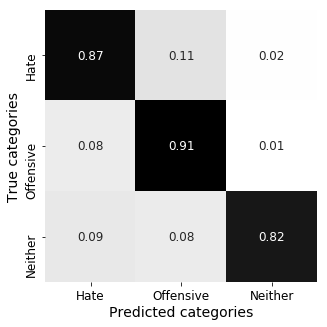

In [45]:
import seaborn
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(df_train.label, predict_labels)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)